<img src='https://hammondm.github.io/hltlogo1.png' style="float:right">

Linguistics 578<br>
Fall 2023<br>
Hammond

## Things to remember about any homework assignment:

1. For this assignment, you will edit this jupyter notebook and turn it in. Do not turn in pdf files or separate `.py` files.
1. Late work is not accepted.
1. Given the way I grade, you should try to answer *every* question, even if you don't like your answer or have to guess.
1. You may *not* use `python` modules that we have not already used in class.
1. You may certainly talk to your classmates about the assignment, but everybody must turn in *their own* work. It is not acceptable to turn in work that is essentially the same as the work of classmates.
1. All code must run. It doesn't have to be perfect, it may not do all that you want it to do, but it must run without error.
1. Code must run in reasonable time. Assume that if it takes more than *5 minutes* to run (on your machine), that's too long.
1. Please do not add, remove, or copy autograded cells.
1. Make sure to select `restart, run all cells` from the `kernel` menu when you're done and before you turn this in!

***

***my name***: Ashwin Raj

***people I talked to about the assignment***: [put your answer here]

***

## Homework #6

Here are the imports. Please do not import anything else.

In [1]:
import os,re
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio

1. We need to use the `kal` database, so here's a question that just lets you specify where it is and then checks that. (Please leave the first two comment lines in place and just add your own below.)

In [2]:
#kal = '/mhdata/cmu_us_kal_diphone/'
#kal = ?
# YOUR CODE HERE
kal = '/mhdata/cmu_us_kal_diphone/cmu_us_kal_diphone/'

In [3]:
assert len(os.listdir(kal)) == 20

We need these from this week's notebook. I've converted the code that creates the diphone database into a function. Make sure the run the cell below before going on.

In [4]:
def getbit(start,end,filename,dirname=kal):
    sr,w = wavfile.read(dirname+'wav/'+filename)
    startidx = int(sr * start)
    endidx = int(sr*end)
    return w[startidx:endidx]

def makeDiphones(where):
    diphones = {}
    for i in range(1,1350):
        filename = str(i)
        while len(filename) < 4: filename = '0' + filename
        filename = 'kal_' + filename + '.lab'
        f = open(kal+'lab/'+filename,'r')
        t = f.read()
        f.close()
        t = re.sub(' 26 ','',t)
        t = t.split('\n')
        t = t[3:-1]
        fset = []
        start = 0
        for line in t:
            bits = line.split('\t')
            bits = bits[1:]
            fset.append((float(start),float(bits[0]),bits[1]))
            start = bits[0]
        i = 1
        while i < len(fset):
            diphone = fset[i-1][2] + '-' + fset[i][2]
            start = (fset[i-1][1] - fset[i-1][0])/2 + fset[i-1][0]
            end = (fset[i][1] - fset[i][0])/2 + fset[i][0]
            filename = re.sub('\.lab$','.wav',filename)
            triple = (filename,start,end)
            if diphone in diphones:
                diphones[diphone].append(triple)
            else:
                diphones[diphone] = [triple]
            i += 1
    return diphones

diphones = makeDiphones(kal)

2. For this question, you need to download and unzip the CMU pronouncing dictionary from [here](https://github.com/Alexir/CMUdict). (Again, do not remove the first two lines below; just add your own below.)

In [5]:
#cmufile = '/mhdata/CMUdict-master/cmudict-0.7b'
#cmufile = ?
# YOUR CODE HERE
cmufile = '/mhdata/cmudict-0.7b'

In [6]:
f = open(cmufile,'rb')
t = f.read()
f.close()
cmudict = t.decode('ISO-8859-1')
assert np.isclose(len(cmudict),3865710,atol=2)

3. Your task is to parse the `cmudict` variable into a dictionary from words to letter sequences. Be mindful of the following:
  1. The file format is funky.
  2. There may be errors and irregularities to recover from.
  3. You have to remove the header lines and final empty line.
  4. You have to convert to lower case.
  5. You have to remove stress information.
  6. You have to accommodate the fact that some words have multiple pronunciations.

In [7]:
def makeDictionary(datafile):
    '''map the cmudict text file to a dictionary
    args:
        datafile: the cmudict07b file as a list of lines
    returns:
        a dictionary from spellings to a list of lists of
        characters.
    '''
    # YOUR CODE HERE

    word_dict = {}
    lines = datafile.strip().split('\n')

    start_index = 0
    for i, line in enumerate(lines):
        if line.startswith(';;;'):
            start_index = i + 1
        else:
            break

    for line in lines[start_index:]:
        parts = line.strip().split()

        word = parts[0].lower() 
        phonemes = parts[1:]

        phonemes = [ph[:-1].lower() if ph[-1].isdigit() else ph.lower() for ph in phonemes]

        if '(' in word and not re.match(r"^\(",word):
            base_word = word.split('(')[0]
            if base_word in word_dict:
                word_dict[base_word].append(phonemes)
            else:
                word_dict[base_word] = [phonemes]
        else:
            if word in word_dict:
                word_dict[word].append(phonemes)
            else:
                word_dict[word] = [phonemes]

    return word_dict


In [8]:
d = makeDictionary(cmudict)
assert len(d) == 125770

In [9]:
assert d['tomato'] == [
    ['t', 'ah', 'm', 'ey', 't', 'ow'],
    ['t', 'ah', 'm', 'aa', 't', 'ow']
]

In [10]:
assert d["didn't"] == [
    ['d', 'ih', 'd', 'ah', 'n', 't'],
    ['d', 'ih', 'd', 'n', 't'],
    ['d', 'ih', 'd', 'ah', 'n'],
    ['d', 'ih', 'n', 't']
]

4. Now write a function that takes a sentence, breaks it into words, looks up those words, converts the transcription to diphones, and returns a list of diphones. In this exercise, we'll keep word transitions simple and separate all words with `pau`. (If a word is not in the dictionary, the function should return *uh* in its stead.)

In [11]:
def sentence2diphones(s,c):
    '''converts a sentence into a sequence of diphones
    args:
        s: a sentence as a string
        c: cmu dictionary as a dictionary
    returns:
        a list of diphones with 'pau' at the beginning
        and end, and between words
    '''
    # YOUR CODE HERE
    diphones = []

    words = s.split()
    word_start = True

    for word in words:

        word_clean = re.sub(r'[.,!?;]', '', word).lower()

        if word_clean not in c:
            word_clean = 'uh'

        phonemes = c[word_clean][0]

        if word_start and len(phonemes) > 0:
            diphones.append(f'pau-{phonemes[0]}')
            word_start = False

        for i in range(len(phonemes) - 1):
            diphone = f'{phonemes[i]}-{phonemes[i + 1]}'
            diphones.append(diphone)

        if len(phonemes) > 0:
            diphones.append(f'{phonemes[-1]}-pau')

        if word != words[-1]:
            diphones.append('pau')
            word_start = True
    diphones = [i for i in diphones if i != 'pau']
    return diphones

In [12]:
words = "I'm feeling pretty optimistic right now."
res = sentence2diphones(words,d)
assert len(res) == 33

In [13]:
assert res == [
    'pau-ay','ay-m','m-pau','pau-f','f-iy',
    'iy-l','l-ih','ih-ng','ng-pau','pau-p',
    'p-r','r-ih','ih-t','t-iy','iy-pau',
    'pau-aa','aa-p','p-t','t-ih','ih-m',
    'm-ih','ih-s','s-t','t-ih','ih-k',
    'k-pau','pau-r','r-ay','ay-t','t-pau',
    'pau-n','n-aw','aw-pau'
]

In [14]:
words = "The bznork sings!"
res = sentence2diphones(words,d)
assert res == [
    'pau-dh','dh-ah','ah-pau','pau-ah','ah-pau',
    'pau-s','s-ih','ih-ng','ng-z','z-pau'
]

5. Finally, let's write a function that takes a list of diphones and creates a wave file.

In [15]:
def makeWave(s,dps):
    '''converts a sequence of diphones into a wave
    args:
        s: a sequence of diphones
        dps: diphone database
    returns:
        a wave as a numpy array
    '''
    # YOUR CODE HERE
    
    sample_rate = 16000
    diphone_duration = 0.2595 
    wave = np.array([])

    diphone_database = dps
    for diphone in s:
        waveform = diphone_database.get(diphone, [0.0]) 
        waveform = np.array(waveform)
        if waveform.ndim > 1:
            waveform = waveform.flatten()

        if len(waveform) < int(sample_rate * diphone_duration):
            waveform = np.concatenate((waveform, np.zeros(int(sample_rate * diphone_duration) - len(waveform))))
        wave = np.concatenate((wave, waveform))

    return wave


In [16]:
s = "I like pancakes."
res = sentence2diphones(s,d)
w = makeWave(res,diphones)
assert type(w) == np.ndarray

In [17]:
assert np.isclose(len(w),58119,atol=50)

And now, just for fun, you can look at and listen to what you've made:

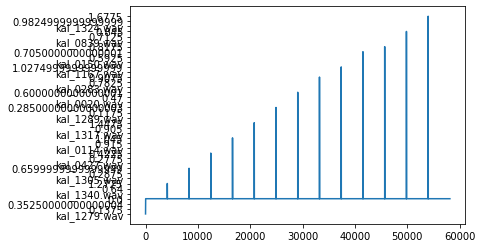

In [18]:
plt.plot(w)
plt.show()

In [19]:
Audio(w,rate=16000)

ValueError: could not convert string to float: 'kal_1279.wav'